# CIFAR-10 Exploratory Data Analysis

## Imports and Dataset Introduction

The CIFAR-10 dataset was created by Alex Krizhevsky, Vinod Nair and Geoffrey Hinton and is a widely used benchmark dataset for computer vision and deep learning applications. It is composed of 60_000 images divided into 10 classes. All images are low res 32x32 pixels, stored as 3D arrays with RGB values normalized between 0 and 255 (for each pixel).

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import cv2
import random

In [3]:
# This cell needs to be run just once
transform = transforms.Compose([transforms.ToTensor()])

# Files are downloaded to data directory within local repo
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

## Check dataset info and class imbalances

### Section takeaways

In this section we start by confirming the dataset size and distribution. As previously mentioned it is composed of 60_000 images, divided into 10 datasets. In the cell below, the dataset was split into train and test subsets with 50_000 and 10_000 images, respetively. The classes are perfectly balanced, each containing 6_000 images (5_000 on the train set and 1_000 on the test set). It was also known that all images are the same size (problems could arise when training the model if this weren't the case).

A visual inspection of the images was then performed using a function created to display 10 random images and their associated label. Running this cell a few times allows for a better understanding of the dataset and do a first inspection for imbalances in image colors, shape, orientation and other features. Upon first inspection one can also see that within each class variable backgrounds appear. This should not influence the model to be trained in a significant way, but its influence should be taken into considereation, particularly when analysing color data, during the present EDA. This, of course, does not replace further more extensive examination.

For that we start by iterating through the `train_set`, flattening the multidimensional tensor with each of the images pixel intensity and concatenating this info for all 50_000 images in the set. This yields a histogram of pixel intensity distribution, showing a relatively normal distribution centered around 0.4.

We then plotted the RGB variance for each class. In theory, if RGB variance for a given class was very low it means that there is little color variation between the images. This could indicate the presence of a large number of similar colored objects (e.g. all planes being white or all cats being black) which could present an overfitting problem further down the line. This was actually the case. However, given the fact that this is known to be a balanced dataset, the low variance values could also be justified by similarities in the surrounding enviroment of the object in each image (e.g. all deers were photographed in the forest so all images in that class have a color distribution skewed to green).
A average color value was the calculated for each of the images by averaging the values of red, green and blue between all pixels in each image and outputting the corresponding color. This showed litle variation, although classes like deer or bird appeared to be slightly more on the green side which could corroborate what was mentioned earlier about each subjects surroundings.

In [6]:
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")
print(f"Classes: {train_set.classes}")

Train samples: 50000, Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
def filter_class(dataset, class_idx):
    number_objects = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return number_objects


for idx in range(len(train_set.classes)):
    objects_inclass = filter_class(train_set, class_idx=idx)  # Select class with index=idx
    print(f"Number of samples in '{train_set.classes[idx]}' class: {len(objects_inclass)}")

Number of samples in 'airplane' class: 5000
Number of samples in 'automobile' class: 5000
Number of samples in 'bird' class: 5000
Number of samples in 'cat' class: 5000
Number of samples in 'deer' class: 5000
Number of samples in 'dog' class: 5000
Number of samples in 'frog' class: 5000
Number of samples in 'horse' class: 5000
Number of samples in 'ship' class: 5000
Number of samples in 'truck' class: 5000


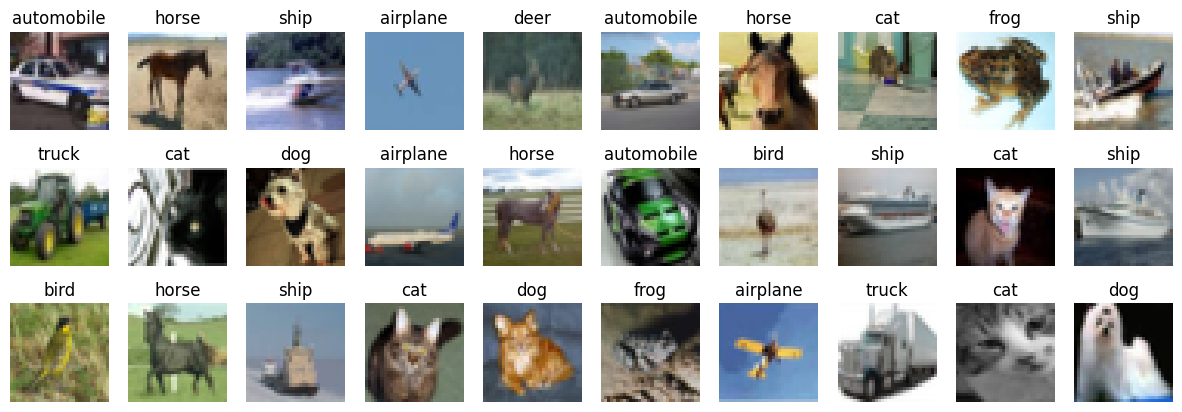

In [7]:
def show_images(dataset, classes, rows=3, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for row in range(rows):
        for col in range(cols):
            img, label = dataset[np.random.randint(len(dataset))]
            ax = axes[row, col]
            ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
            ax.set_title(classes[label])
            ax.axis('off')
    plt.show()

show_images(train_set, train_set.classes)

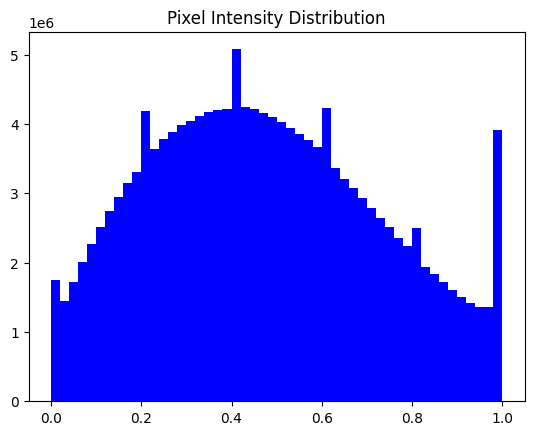

In [91]:
def pixel_intensity_distribution(dataset):
    data = torch.cat([d[0].flatten() for d in dataset])
    plt.hist(data, bins=50, color='blue')
    plt.title("Pixel Intensity Distribution")
    plt.show()

pixel_intensity_distribution(train_set)

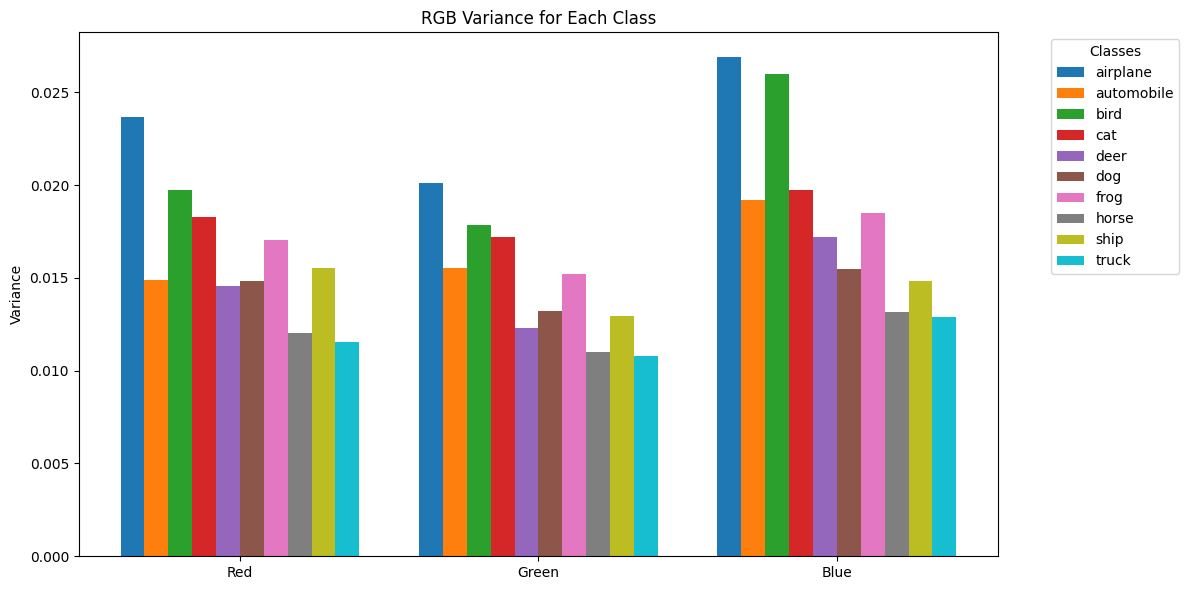

In [48]:
def filter_class_subset(dataset, class_idx):
    indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return Subset(dataset, indices)

def compute_class_color_variance(dataset, class_idx):
    class_subset = filter_class_subset(dataset, class_idx)
    mean_colors = []

    for img, _ in class_subset:
        mean_color = img.view(3, -1).mean(dim=1).numpy()
        mean_colors.append(mean_color)

    mean_colors = np.array(mean_colors)
    variance = np.var(mean_colors, axis=0)
    return variance

variances = []

for idx in range(0, len(train_set.classes)):
    variance = compute_class_color_variance(train_set, class_idx=idx)
    # print(f"Variance in class '{train_set.classes[idx]}' is {variance}")
    variances.append(variance)

variances = np.array(variances)

rgb_channels = ['Red', 'Green', 'Blue']

x = np.arange(len(rgb_channels))
width = 0.08  # Width of each bar
fig, ax = plt.subplots(figsize=(12, 6))

for i, class_name in enumerate(train_set.classes):
    ax.bar(x + i * width, variances[i], width, label=class_name)

ax.set_xticks(x + (len(train_set.classes) * width) / 2 - width / 2)
ax.set_xticklabels(rgb_channels)
ax.set_ylabel('Variance')
ax.set_title('RGB Variance for Each Class')
ax.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

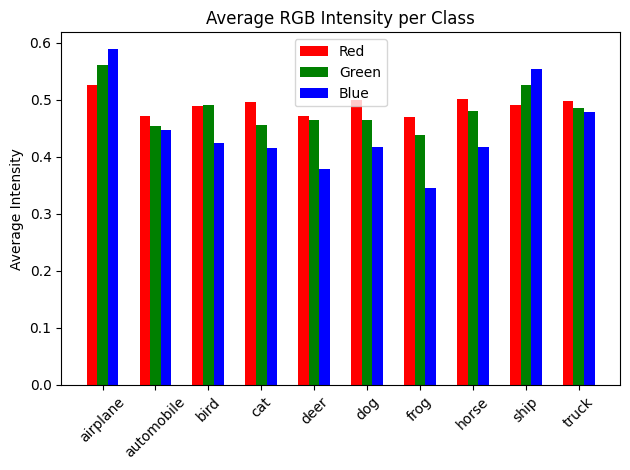

In [92]:
def compute_color_distribution(dataset, num_classes=10):
    avg_colors = torch.zeros((num_classes, 3))
    counts = torch.zeros(num_classes)

    for img, label in dataset:
        avg_colors[label] += img.view(3, -1).mean(dim=1)
        counts[label] += 1

    avg_colors /= counts.unsqueeze(1)
    return avg_colors.numpy()

avg_colors = compute_color_distribution(train_set)

class_names = train_set.classes
x = np.arange(10)
plt.bar(x - 0.2, avg_colors[:, 0], width=0.2, label='Red', color='red')
plt.bar(x, avg_colors[:, 1], width=0.2, label='Green', color='green')
plt.bar(x + 0.2, avg_colors[:, 2], width=0.2, label='Blue', color='blue')
plt.xticks(x, class_names, rotation=45)
plt.ylabel('Average Intensity')
plt.title('Average RGB Intensity per Class')
plt.legend()
plt.tight_layout()
plt.show()

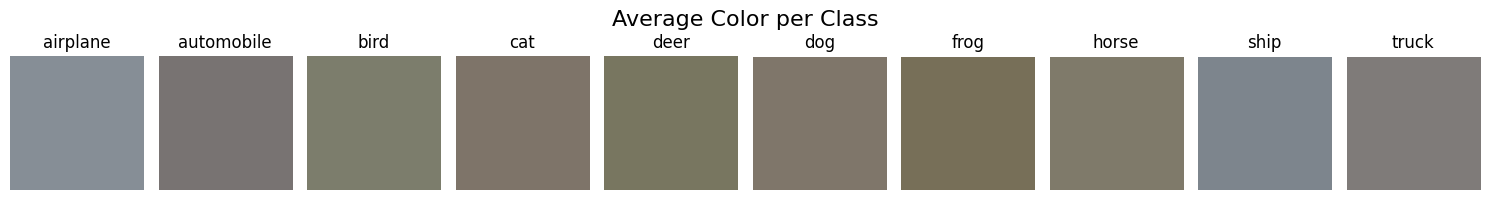

In [58]:
fig, ax = plt.subplots(1, 10, figsize=(15, 2))

for i in range(len(avg_colors)):
    ax[i].imshow([[avg_colors[i]]])
    ax[i].axis('off')
    ax[i].set_title(f'{train_set.classes[i]}')

fig.suptitle('Average Color per Class', fontsize=16)
plt.tight_layout()
plt.show()

## Average image and Eigenimages

### Section takeaways

The average image was calculated for each class. Although this technique is not as appropriate for a dataset with such a variety of different images in each class, it is still useful to have a clearer view of average color, shape occupied by subject in each class and background characteristics.

Next, we plotted the eigenimages for each of the classes. The process starts by flatenning the images into a 3072 value vector (32x32x3), as seen in previous steps. We will the use Principal Component Analysis (PCA), imported from `sklearn`, on the resulting vectors and then reshaping them back to a 32x32 image. The plots show the images resulting from the first principal component and outline the most significant patterns in each of the classes.

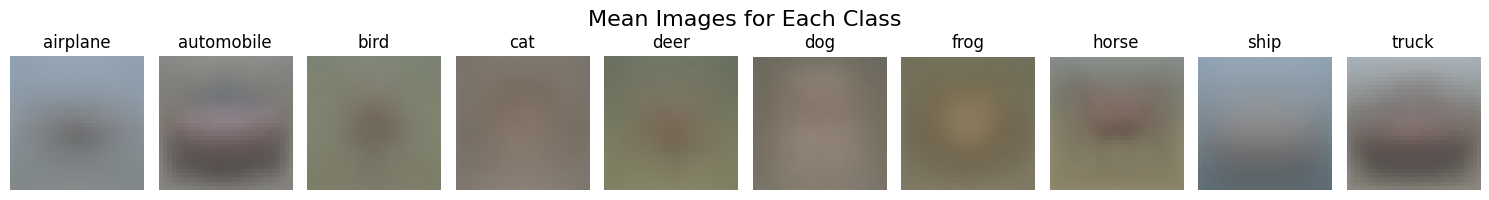

In [78]:
def mean_img(dataset):
    mean_images = []

    for class_idx in range(len(dataset.classes)):
        class_images = dataset.data[np.array(dataset.targets) == class_idx]
        
        mean_image = np.mean(class_images, axis=0)
        mean_images.append(mean_image)

    mean_images = np.array(mean_images)

    fig, ax = plt.subplots(1, 10, figsize=(15, 2))

    for i, mean_image in enumerate(mean_images):
        ax[i].imshow(mean_image.astype('uint8'))
        ax[i].axis('off')
        ax[i].set_title(f'{dataset.classes[i]}')

    plt.suptitle('Mean Images for Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

mean_img(train_set)

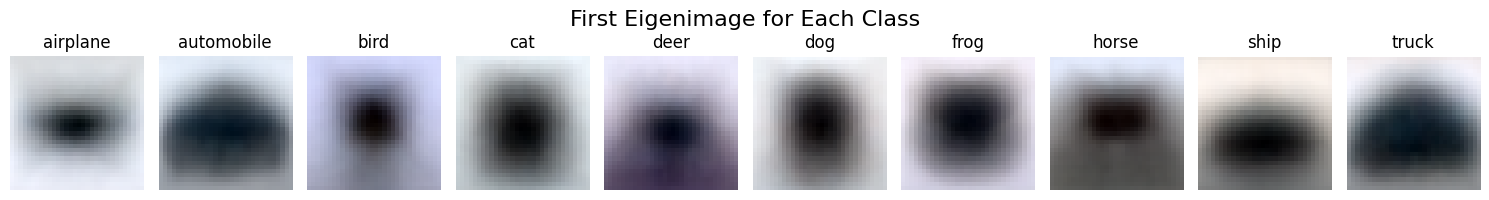

In [87]:
def eingen_img(dataset):
    n_components = 5

    eigenimages = []

    for class_idx in range(len(dataset.classes)):
        class_images = dataset.data[np.array(dataset.targets) == class_idx]
        
        n_samples, height, width, channels = class_images.shape
        class_images_flat = class_images.reshape(n_samples, -1)
        
        pca = PCA(n_components=n_components)
        pca.fit(class_images_flat)
        
        eigenvectors = pca.components_.reshape(n_components, height, width, channels)
    
        # Normalizing eigenvectors to fit in 0-255 range for RGB space
        eigenvectors_normalized = []

        for eigenvector in eigenvectors:
            eigenvector_min = eigenvector.min()
            eigenvector_max = eigenvector.max()
            normalized = 255 * (eigenvector - eigenvector_min) / (eigenvector_max - eigenvector_min)
            eigenvectors_normalized.append(normalized)
        
        eigenimages.append(eigenvectors_normalized)

    eigenimages = np.array(eigenimages)

    fig, ax = plt.subplots(1, 10, figsize=(15, 2))

    for i in range(len(dataset.classes)):
        ax[i].imshow(eigenimages[i, 0].astype('uint8'))
        ax[i].axis('off')
        ax[i].set_title(f'{dataset.classes[i]}')

    plt.suptitle('First Eigenimage for Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

eingen_img(train_set)

## Detecting main subject occupied area

### Section takeaways

The subject's outline was found for each of the images. For this the OpenCV librarie was used. The first cell plots 10 random images and the defined subject contour. This allows for verification of contour accuracy. After this, the avg area occupied by each of the categories subjects was calculated. With this a comparison could be made between the relative space occupied by the subject within the frame. Lastly, a histogram for each class shows subject size distribution. This is important to verify that an even spread of subject sizes exists within each of the classes. Subjects that are consistently the same size can lead to model overfitting later down the line and it is something to be aware of.

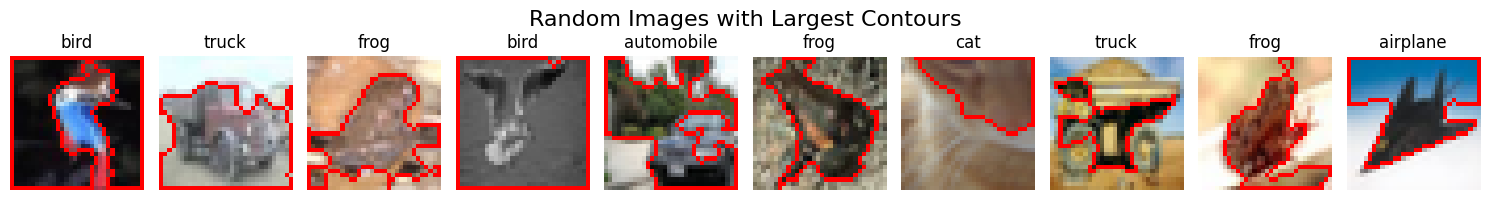

In [40]:
# A lot of contours fail to capture correct subject outline
def plot_contours(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    sampled_images = random.sample(list(dataset), num_images)

    for i, (img, label) in enumerate(sampled_images):
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        gray = cv2.cvtColor((img_np * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            img_with_contour = cv2.drawContours(img_np.copy(), [largest_contour], -1, (1, 0, 0), 1)
        else:
            img_with_contour = img_np
                
        axes[i].imshow(img_with_contour)
        axes[i].axis('off')
        axes[i].set_title(dataset.classes[label])

    plt.suptitle("Random Images with Largest Contours", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_contours(train_set, num_images=10)

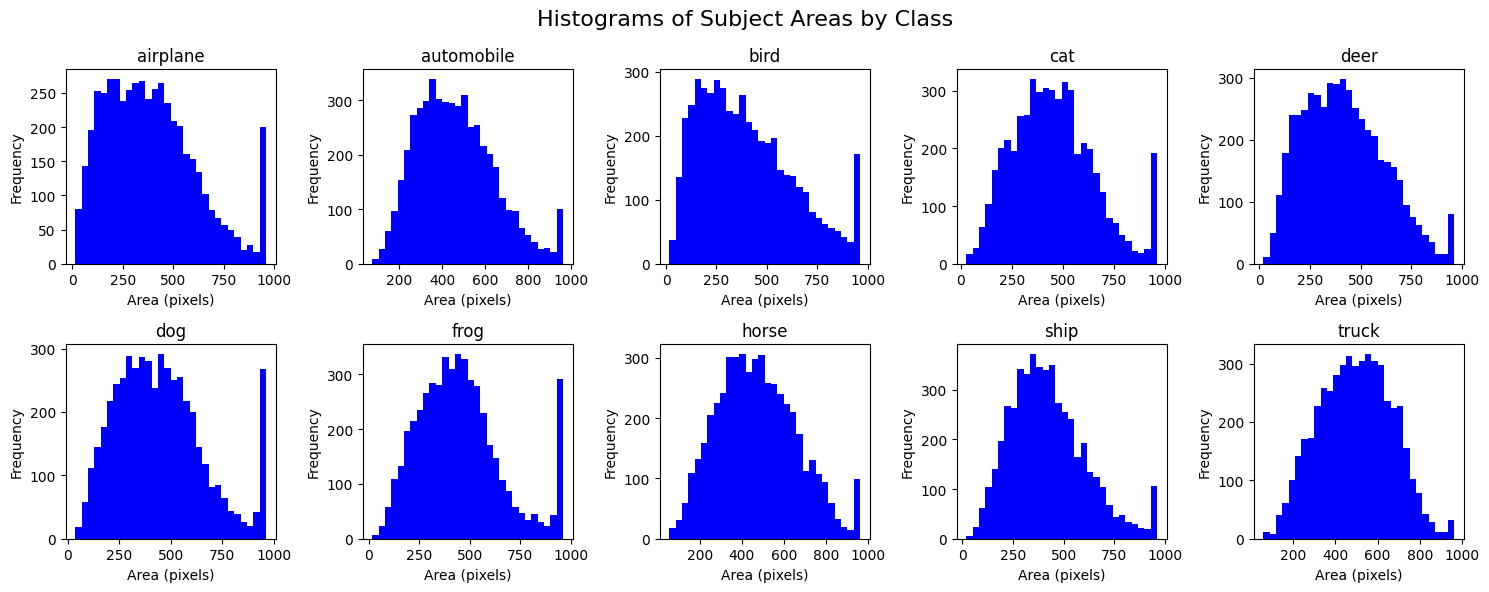

Avg area occupied by 'airplane': 390.00 pixels
Avg area occupied by 'automobile': 462.25 pixels
Avg area occupied by 'bird': 397.49 pixels
Avg area occupied by 'cat': 454.91 pixels
Avg area occupied by 'deer': 417.13 pixels
Avg area occupied by 'dog': 449.10 pixels
Avg area occupied by 'frog': 453.53 pixels
Avg area occupied by 'horse': 473.48 pixels
Avg area occupied by 'ship': 422.86 pixels
Avg area occupied by 'truck': 495.92 pixels


In [41]:
def detect_subject(dataset):
    class_areas = {label: [] for label in dataset.classes}

    for img, label in dataset:
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        gray = cv2.cvtColor((img_np * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            class_areas[dataset.classes[label]].append(area)

    avg_areas = {label: np.mean(areas) if areas else 0 for label, areas in class_areas.items()}

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for idx, (class_name, areas) in enumerate(class_areas.items()):
        axes[idx].hist(areas, bins=30, color='blue')
        axes[idx].set_title(f"{class_name}")
        axes[idx].set_xlabel('Area (pixels)')
        axes[idx].set_ylabel('Frequency')
        
    plt.suptitle("Histograms of Subject Areas by Class", fontsize=16)
    plt.tight_layout()
    plt.show()

    return avg_areas

avg_class_areas = detect_subject(train_set)

for class_name, avg_area in avg_class_areas.items():
    print(f"Avg area occupied by '{class_name}': {avg_area:.2f} pixels")